# Examples

This notebook contains examples on how to use pySOLRAD for synthesizing radio waves from a bipolar sunspot and the full disk.

[Skip to full-disk synthesis](#full-disk-synthesis)

# Sunspot Synthesis

### Load atmosphere from MURaM MHD model

Includes temperature, magnetic field vector, and density distributions in CGS units

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm,LogNorm
from numba import njit, jit, prange
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'

path = './models/MURaM/sunspot/'
hdr = np.loadtxt(path+'Header.050000')
dsh = np.flip(hdr[0:3].astype(int))
dx = np.flip(hdr[3:6])
tstep = hdr[6] 
itn_str = '050000'
print('Box dimensions: ',dsh)
print('Sampling in cm: ',dx)

ztau1 = 155
height_km = (np.arange(dsh[2])-ztau1)*dx[2]/1e5 # height (km)
y_km = np.linspace(-dsh[1]/2*dx[1]/1e5,dsh[1]/2*dx[1]/1e5,dsh[1]) # y
x_km = np.linspace(-dsh[0]/2*dx[0]/1e5,dsh[0]/2*dx[0]/1e5,dsh[0]) # x
imgext = (x_km[0],x_km[-1],y_km[0],y_km[-1])
memload = lambda name: np.memmap(path + name + '.' + itn_str, dtype=np.float32, mode='r', shape=(dsh[0], dsh[1], dsh[2]))

print('loading temp')
temp = memload('eosT') # temp (K)
print('loading density')
mdens = memload('result_prim_0') # mass density
mprot = 1.672619e-24
ne = mdens / mprot * (1.+0.7)/2. # electron density (cm-3)
print('loading mag field: bz', end=' ')
bz = np.sqrt(4.*np.pi) * memload('result_prim_5') # mag field components (Ga)
print('bx', end=' ')
bx = np.sqrt(4.*np.pi) * memload('result_prim_6')
print('by', end=' ')
by = np.sqrt(4.*np.pi) * memload('result_prim_7')
print('btot', end=' ')
btot = np.sqrt(bx**2 + by**2 + bz**2) # total mag field
print('binclos', end=' ')
binclos = np.arccos(- by / btot) # inclination angle relative to surface
print('bazilos')
bazilos = np.arctan2( bx , bz) # azimuth angle
print('type matching: temp', end=' ')
temp = temp.astype(np.float32)
print('btot', end=' ')
btot = btot.astype(np.float32)
print('bz', end=' ')
bz = bz.astype(np.float32)
print('ne', end=' ')
ne = ne.astype(np.float32)
print('dx', end=' ')
dx = dx.astype(np.float32)
print('done')
dl = dx[-1]

Box dimensions:  [ 512 1024 1024]
Sampling in cm:  [9600000. 9600000. 4800000.]
loading temp
loading density
loading mag field: bz bx by btot binclos bazilos
type matching: temp btot bz ne dx done


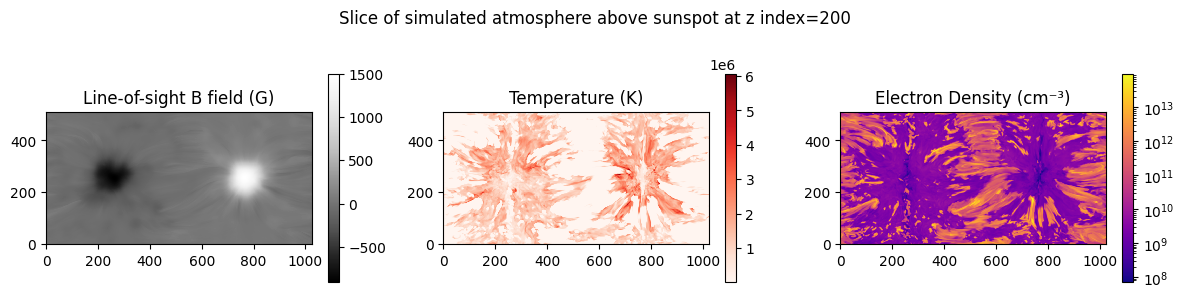

In [2]:
zidx = 200
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(bz[:, :, zidx], cmap='Greys_r')
axs[0].set_title(f"Line-of-sight B field (G)")
fig.colorbar(im0, ax=axs[0], shrink=0.5)
im1 = axs[1].imshow(temp[:, :, zidx], cmap='Reds')
axs[1].set_title("Temperature (K)")
fig.colorbar(im1, ax=axs[1], shrink=0.5)
im2 = axs[2].imshow(ne[:, :, zidx], cmap='plasma', norm='log')
axs[2].set_title("Electron Density (cm⁻³)")
fig.colorbar(im2, ax=axs[2], shrink=0.5)
plt.suptitle(f'Slice of simulated atmosphere above sunspot at z index={zidx}')
plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()

### Synthesize bremsstrahlung, gyroresonance, and faraday rotation

In [3]:
import pysolrad

print('Generating rays through z axis...')
rays = pysolrad.RayCollection(temp, btot, bz, ne, dl, axis = 2) # iterate through z axis (generate image looking in the xy plane)
print('Synthesizing at 1GHz (1e9Hz)...')
img = pysolrad.synthesize(rays, v=1e9, dogyro=True) # synthesize bremsstrahlung with gyroresonance (dogyro)
print('done')

Generating rays through z axis...
Synthesizing at 1GHz (1e9Hz)...
done


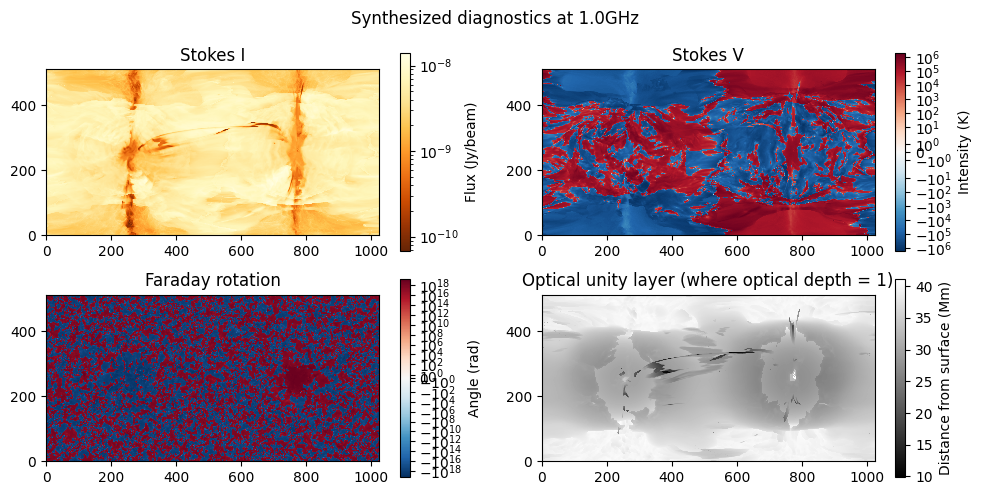

In [4]:

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
im0 = axs[0, 0].imshow(img.I.to('Jy/beam'), cmap='YlOrBr_r', norm='log')
axs[0, 0].set_title('Stokes I')
fig.colorbar(im0, ax=axs[0, 0], label='Flux (Jy/beam)')
im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
axs[0, 1].set_title('Stokes V')
fig.colorbar(im1, ax=axs[0, 1], label='Intensity (K)')
im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
axs[1, 0].set_title('Faraday rotation')
fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)')
im3 = axs[1, 1].imshow(img.unity.to('Mm'), cmap='gray')
axs[1, 1].set_title('Optical unity layer (where optical depth = 1)')
fig.colorbar(im3, ax=axs[1, 1], label='Distance from surface (Mm)')
plt.suptitle(f'Synthesized diagnostics at {pysolrad.Quantity(img.v, 'Hz').to('GHz')}GHz')
plt.tight_layout()
plt.show()

# Full-disk synthesis

### Load atmosphere from PSI's MAS MHD model

Includes temperature, magnetic field vector, and density distributions in CGS units

In [5]:
import models.MAS.mas as mas
from sunpy.coordinates import sun
import numpy as np
from numba import njit, prange
import sunpy.sun.constants as constants
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

# Setup PSI model
print("Importing coronal model... ", end="")
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = mas.Model('./models/MAS/corona_cr2194/') #cr2194
print("done")

# Setup observer
print("Initializing observer and image plane... ", end="")
crn= sun.carrington_rotation_number('2017-08-21T12:00:00.000') #2247
crt = sun.carrington_rotation_time(crn)
obsLon = sun.L0(crt).rad
obsLat = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc = sun.angular_radius(crt).value
rObs = Obs_Sun_AU * constants.astronomical_unit.value/constants.radius.value
thetaObs = np.pi / 2 - obsLat
phiObs = obsLon

# Create image
rsunarc = 960
arcsamp = 20.
arc = np.linspace(-3 * rsunarc, 3 * rsunarc, int(6 * rsunarc / arcsamp))
zza, yya = np.meshgrid(arc, arc, indexing='ij')
zza = np.flipud(zza)
mask_ondisk = (np.hypot(zza, yya) > rsunarc).astype(float)

# Project to solar tangent plane
yy = rObs * np.tan(np.deg2rad(yya / 3600.))
zz = rObs * np.tan(np.deg2rad(zza / 3600.))
rr = np.hypot(yy, zz)
xx = np.zeros_like(rr)
xx[rr < 1] = np.sqrt(1 - rr[rr < 1]**2)
print("done")

# Create rays
print("Creating rays through image plane... ", end="")
rot = euler_ry(thetaObs - np.pi/2) @ euler_rz(phiObs)
starts = (rot @ np.stack([xx.ravel(), yy.ravel(), zz.ravel()])).T
obs_vec = rObs * np.array([
    np.sin(thetaObs) * np.cos(phiObs),
    np.sin(thetaObs) * np.sin(phiObs),
    np.cos(thetaObs)
])
los = obs_vec - starts
los /= np.linalg.norm(los, axis=1, keepdims=True)

start_r = 2.0 # start this many solar radii from sun's center
deltaR_forward = corona.rs - start_r
deltaR_forward = deltaR_forward[deltaR_forward >= 0]
deltaR_bidirectional = np.cumsum(np.diff(corona.rs))
deltaR_bidirectional = np.hstack([-deltaR_bidirectional[::-1], deltaR_bidirectional])
deltaR = np.zeros((len(deltaR_bidirectional), starts.shape[0]))
on_disk = np.linalg.norm(starts, axis=1) <= 1.0
deltaR[:len(deltaR_forward), on_disk] = deltaR_forward[:, None]
deltaR[:len(deltaR_bidirectional), ~on_disk] = deltaR_bidirectional[:, None]
rays_xyz = starts[None] + deltaR[:, :, None] * los[None]

# Convert to spherical coordinates
r = np.linalg.norm(rays_xyz, axis=2)
theta = np.arccos(rays_xyz[:, :, 2] / r)
phi = np.mod(np.arctan2(rays_xyz[:, :, 1], rays_xyz[:, :, 0]), 2 * np.pi)
rays_sph = np.stack([phi, theta, r], axis=-1).reshape(-1, 3)
print('done')

# Interpolation
print("Interpolating plasma and magnetic field values... ", end="")
def interp(field, name):
    print(f"({name}) ", end="")
    return rgi(
        (corona.phis, corona.thetas, corona.rs),
        field,
        method='linear',
        fill_value=0.0,
        bounds_error=False
    )(rays_sph).reshape(r.shape)
bx_rays = interp(corona.bx, "bx")
by_rays = interp(corona.by, "by")
bz_rays = interp(corona.bz, "bz")
ne_rays = interp(corona.ne, "density")
temp_rays = interp(corona.temp, "temp")
print("done")

# B-field projections
print("Projecting B-fields along LOS... ", end="")
bvec = np.stack([bx_rays, by_rays, bz_rays], axis=-1)
lvec = rays_xyz / (np.linalg.norm(rays_xyz, axis=2, keepdims=True) + 1e-15)
blos_rays = np.sum(bvec * lvec, axis=2)
btot_rays = np.linalg.norm(bvec, axis=2)
# Step sizes
dray = np.linalg.norm(np.diff(rays_xyz, axis=0), axis=2) * constants.radius.value * 100.  # solar radius in cm
print("done")

Importing coronal model... done
Initializing observer and image plane... done
Creating rays through image plane... done
Interpolating plasma and magnetic field values... (bx) (by) (bz) (density) (temp) done
Projecting B-fields along LOS... done


### Synthesis

In [11]:
import pysolrad
import importlib
importlib.reload(pysolrad)

v = 1000e5
rays = pysolrad.RayCollection(temp_rays[:-1], btot_rays[:-1], blos_rays[:-1], ne_rays[:-1], dray, axis=0) # rays can be 2D or 3D - 2D is useful for non-cartesian coordinate systems like polar
img = pysolrad.synthesize(rays, v, dogyro=False).reshape(*yya.shape) # since we only had 2D array of rays, we need to reshape the resulting image

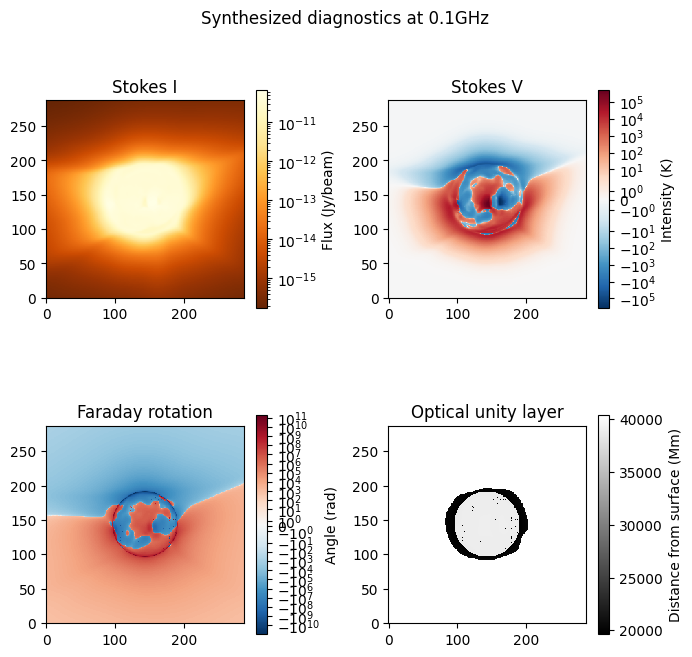

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
im0 = axs[0, 0].imshow(img.I.to('Jy/beam'), cmap='YlOrBr_r', norm='log')
axs[0, 0].set_title('Stokes I')
fig.colorbar(im0, ax=axs[0, 0], label='Flux (Jy/beam)', shrink=0.7)
im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
axs[0, 1].set_title('Stokes V')
fig.colorbar(im1, ax=axs[0, 1], label='Intensity (K)', shrink=0.7)
im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
axs[1, 0].set_title('Faraday rotation')
fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)', shrink=0.7)
im3 = axs[1, 1].imshow(img.unity.to('Mm'), cmap='gray')
axs[1, 1].set_title('Optical unity layer')
fig.colorbar(im3, ax=axs[1, 1], label='Distance from surface (Mm)', shrink=0.7)
plt.suptitle(f'Synthesized diagnostics at {pysolrad.Quantity(img.v, 'Hz').to('GHz')}GHz')
plt.tight_layout()
plt.show()

# 1D synthesis

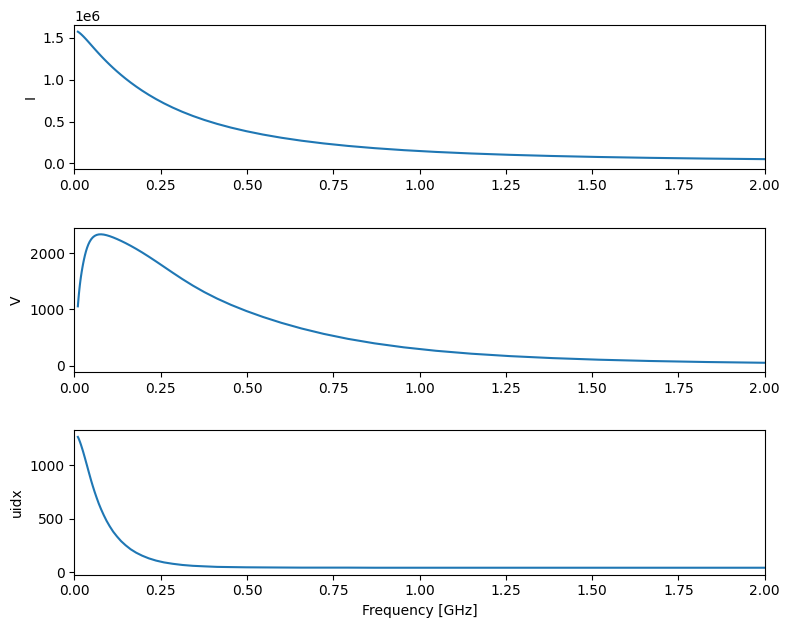

In [16]:
import numpy as np
from io import StringIO
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import njit
import pysolrad

with open('./models/Allen-Solar-Atmosphere.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text_fixed = text.replace('–', '-')
data = np.loadtxt(StringIO(text_fixed), skiprows=1)[:, 1:]
data = data[data[:, 0] >= 0] # filter by positive heights
ht = data[:,0]*1000.*100. # heights
temps = data[:,2] # temperatures
nes = data[:,8]
pg = data[:, 4] # gas pressures
ptot = data[:, 5]  # total pressures
pmag = np.clip(ptot - pg, 0, None)  # magnetic pressures
bb = np.sqrt(8 * np.pi * pmag) # magnetic field along LOS
n_points = ht.size * 10
hts = np.linspace(ht.min(), ht.max(), n_points)

tempInt = interp1d(ht, temps, kind='linear', fill_value='extrapolate')
neInt = interp1d(ht, nes, kind='linear', fill_value='extrapolate')
bbInt = interp1d(ht, bb, kind='linear', fill_value='extrapolate')
temps = tempInt(hts)
nes = neInt(hts)
bb = bbInt(hts)
ht = hts
dl = np.abs(np.diff(ht)) # difference in heights

vs = np.logspace(7, 11, 100) # wavelengths to sample

rays = pysolrad.RayCollection(temps[:-1], bb[:-1], bb[:-1], nes[:-1], dl, False) # dl uses diffs between quantities, we have 1 less data point
images = []
for v in vs:
    img = pysolrad.synthesize(rays, v, dogyro=False)
    images.append(img)
fields = ['I', 'V', 'uidx']
plt.figure(figsize=(8, 10))
for i, field in enumerate(fields, 1):
    vals = [getattr(img, field) for img in images]
    plt.subplot(5, 1, i)
    plt.plot(pysolrad.Quantity(vs, 'Hz').to('GHz'), vals)
    plt.xlim(0, 2)
    plt.ylabel(field)
plt.xlabel("Frequency [GHz]")
plt.tight_layout()
plt.show()